<h2>UNIVARIATE ANALYSIS: Text</h2>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [11]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

sys.path.append(str(Path().resolve().parent))
from src.data_split import get_train_data, get_cv_data, get_test_data, get_train_target, get_test_target, get_cv_target
from sklearn.feature_extraction.text import CountVectorizer



In [26]:
train_df = get_train_data()
test_df = get_test_data()
cv_df = get_cv_data()
y_train = get_train_target()
y_cv = get_cv_target()
y_test = get_test_target()

In [6]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text'])
# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names_out()


# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53748


Total number of Unique words in train data is 53748

<b>Featurize text field : BoW and Tfidf<b>

In [12]:
bow_vectorizer = CountVectorizer(
    min_df=3,          # ignore very rare words
    max_df=0.9,        # ignore extremely frequent words
    ngram_range=(1, 1) # unigrams
)

# Fit ONLY on training data
X_train_bow = bow_vectorizer.fit_transform(train_df["Text"])

# Transform test and CV
X_test_bow = bow_vectorizer.transform(test_df["Text"])
X_cv_bow = bow_vectorizer.transform(cv_df["Text"])



scaler = StandardScaler(with_mean=False)  # sparse-safe

X_train_bow_scaled = scaler.fit_transform(X_train_bow)
X_test_bow_scaled = scaler.transform(X_test_bow)
X_cv_bow_scaled = scaler.transform(X_cv_bow)



In [13]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.9,
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words="english" # optional
)

# Fit ONLY on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

# Transform test and CV
X_test_tfidf = tfidf_vectorizer.transform(test_df["Text"])
X_cv_tfidf = tfidf_vectorizer.transform(cv_df["Text"])

Vocabulary size BOW - Train : 53692
Min frequency BOW - Train : 3
Max frequency BOW - Train : 67146
Mean frequency BOW - Train : 217.4319079192431
Median frequency BOW - Train : 14.0


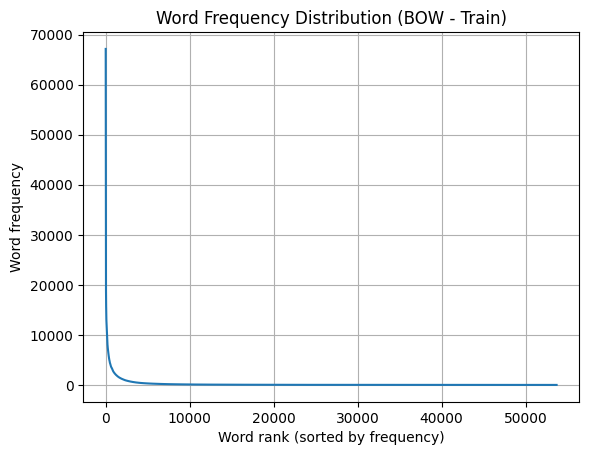

Vocabulary size BOW - CV : 53692
Min frequency BOW - CV : 0
Max frequency BOW - CV : 18496
Mean frequency BOW - CV : 53.428927959472546
Median frequency BOW - CV : 3.0


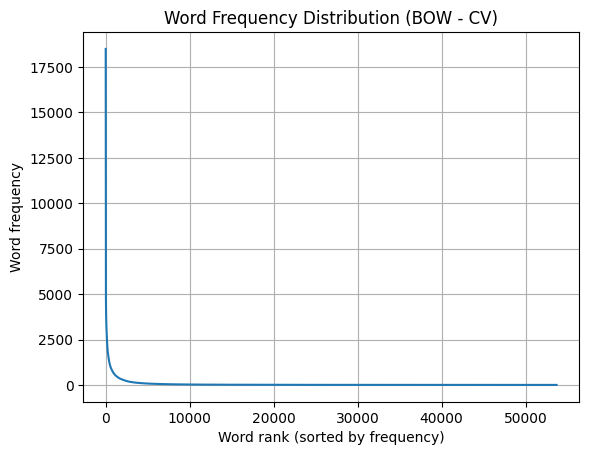

Vocabulary size BOW - Test : 53692
Min frequency BOW - Test : 0
Max frequency BOW - Test : 21223
Mean frequency BOW - Test : 67.7234038590479
Median frequency BOW - Test : 4.0


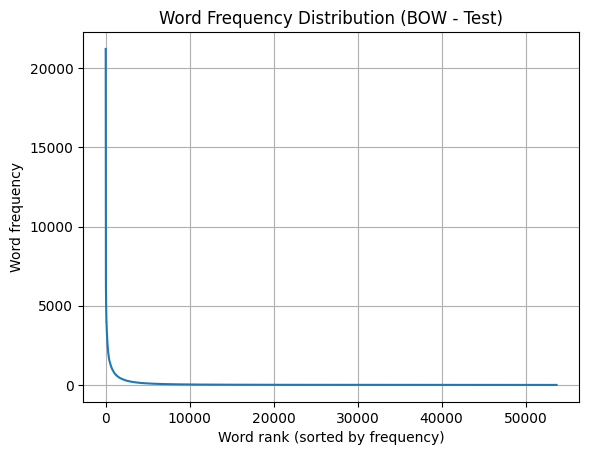

In [25]:
def print_word_frequency_distribution(data, title):
    # Sum counts of each word across all documents
    word_counts = data.sum(axis=0).A1

    sorted_word_counts = np.sort(word_counts)[::-1]
    print("Vocabulary size", title, ":", len(sorted_word_counts))
    print("Min frequency", title, ":", sorted_word_counts.min())
    print("Max frequency", title, ":", sorted_word_counts.max())
    print("Mean frequency", title, ":", sorted_word_counts.mean())
    print("Median frequency", title, ":", np.median(sorted_word_counts))

    plt.figure()
    plt.plot(sorted_word_counts)
    plt.xlabel("Word rank (sorted by frequency)")
    plt.ylabel("Word frequency")
    plt.title("Word Frequency Distribution (" + title + ")")
    plt.grid(True)
    plt.show()

print_word_frequency_distribution(X_train_bow, "BOW - Train")
print_word_frequency_distribution(X_cv_bow, "BOW - CV")
print_word_frequency_distribution(X_test_bow, "BOW - Test")


<h3>Train Logistic regression on BoW dataset</h3>

For values of alpha =  1e-06 The log loss is: 1.4469535449058042
For values of alpha =  1e-05 The log loss is: 1.458295947779935
For values of alpha =  0.0001 The log loss is: 1.440873909491412
For values of alpha =  0.001 The log loss is: 1.4539549414548563
For values of alpha =  0.01 The log loss is: 1.4460212773874732
For values of alpha =  0.1 The log loss is: 1.282540687409268
For values of alpha =  1 The log loss is: 1.2137762477757554


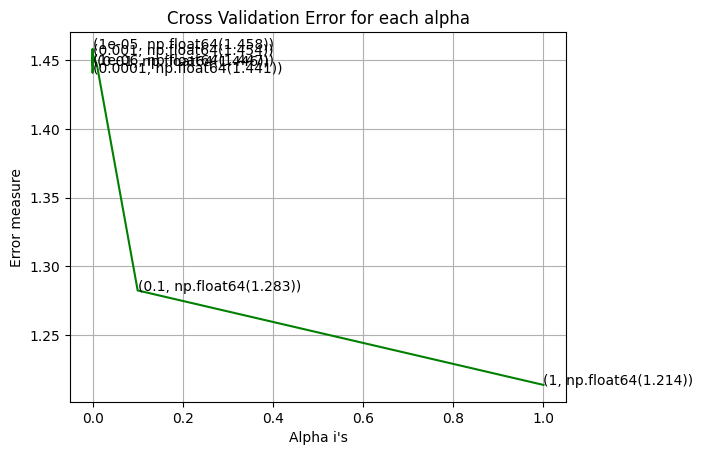

For values of best alpha =  1 The train log loss is: 0.67816991976907
For values of best alpha =  1 The cross validation log loss is: 1.2137762477757554
For values of best alpha =  1 The test log loss is: 1.189656407594851


In [27]:
cv_log_error_array=[]

# selection of hyperparameter alpha
# creation of alpha and their corresponding  logloss
alpha_list = [10 ** x for x in range(-6, 1)] # hyperparam for SGD classifier
for index, alpha in enumerate(alpha_list):
    # define the model as logistic regression
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
    # define the calibration model
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")

    # # training the model(redundant)
    # clf.fit(train_gene_ohe, y_train)

    # training the calibration model
    sig_clf.fit(X_train_bow_scaled, y_train)
    
    # after traning, predict the probability for cv data with the calibration model
    predict_y = sig_clf.predict_proba(X_cv_bow_scaled)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=sig_clf.classes_))
    print('For values of alpha = ', alpha, "The log loss is:", cv_log_error_array[index])

fig, ax = plt.subplots()
ax.plot(alpha_list, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha_list[i],np.round(txt,3)), (alpha_list[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# the best alpha
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha_list[best_alpha], penalty='l2', loss='log_loss', random_state=42)

# redundant
# clf.fit(train_gene_ohe, y_train)

# define calibration model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_bow_scaled, y_train)

predict_y = sig_clf.predict_proba(X_train_bow_scaled)
print('For values of best alpha = ', alpha_list[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_cv_bow_scaled)
print('For values of best alpha = ', alpha_list[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test_bow_scaled)
print('For values of best alpha = ', alpha_list[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_))


<h3>Train Logistic regression on TF-IDF dataset</h3>

For values of alpha =  1e-06 The log loss is: 1.2249208617486798
For values of alpha =  1e-05 The log loss is: 1.0988843759297842
For values of alpha =  0.0001 The log loss is: 1.0667363943317183
For values of alpha =  0.001 The log loss is: 1.139622994255574
For values of alpha =  0.01 The log loss is: 1.2928736498771773
For values of alpha =  0.1 The log loss is: 1.4476722569885814
For values of alpha =  1 The log loss is: 1.5069912953599187


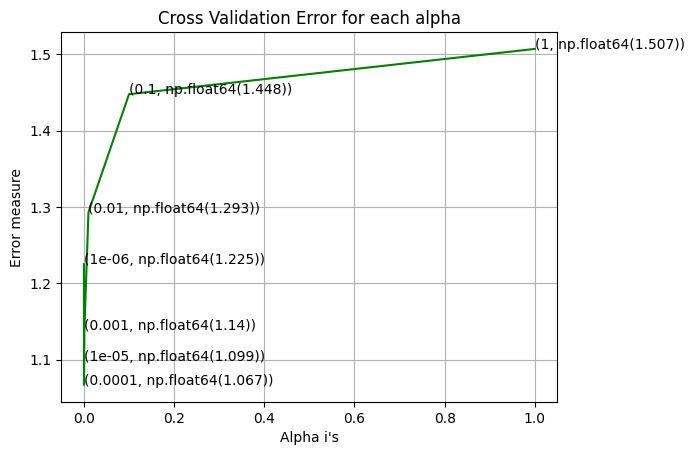

For values of best alpha =  0.0001 The train log loss is: 0.6320593786113942
For values of best alpha =  0.0001 The cross validation log loss is: 1.0667363943317183
For values of best alpha =  0.0001 The test log loss is: 1.0181308574260988


In [28]:
cv_log_error_array=[]

# selection of hyperparameter alpha
# creation of alpha and their corresponding  logloss
alpha_list = [10 ** x for x in range(-6, 1)] # hyperparam for SGD classifier
for index, alpha in enumerate(alpha_list):
    # define the model as logistic regression
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
    # define the calibration model
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")

    # # training the model(redundant)
    # clf.fit(train_gene_ohe, y_train)

    # training the calibration model
    sig_clf.fit(X_train_tfidf, y_train)
    
    # after traning, predict the probability for cv data with the calibration model
    predict_y = sig_clf.predict_proba(X_cv_tfidf)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=sig_clf.classes_))
    print('For values of alpha = ', alpha, "The log loss is:", cv_log_error_array[index])

fig, ax = plt.subplots()
ax.plot(alpha_list, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha_list[i],np.round(txt,3)), (alpha_list[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# the best alpha
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha_list[best_alpha], penalty='l2', loss='log_loss', random_state=42)

# redundant
# clf.fit(train_gene_ohe, y_train)

# define calibration model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha_list[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_cv_tfidf)
print('For values of best alpha = ', alpha_list[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha_list[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [33]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.026 % of word of test data appeared in train data
98.148 % of word of Cross Validation appeared in train data
